In [4]:
import json
import math
from matplotlib import pyplot as plt
from collections import Counter
plt.style.use('ggplot')

In [32]:
def read_in(filename):
    tmp = Counter()
    with open(filename) as f:
        for line in f:
            instance = json.loads(line)

            for k,v in instance['labels'].items():
                for sent_idx,sent_label in enumerate(v['sentence_labels']):
                    tmp[(int(sent_idx), sent_label)] += 1
    return tmp

def normalize(dist,smooth=1e-6):
    return [(a+smooth)/(sum(dist)+smooth) for a in dist]

def D_kl(p,q):
    return sum(pi*math.log(pi/qi,2) for pi,qi in zip(p,q))
    

In [83]:
labels = Counter()

labels.update(read_in("ncmace95/train.jsonl"))
labels.update(read_in("ncmace95/dev.jsonl"))
labels.update(read_in("ncmace95/test.jsonl"))


pos = []
val = []

cum_totals_true = [0]
cum_totals_false = [0]

for idx in range(101):
    pos.append(idx)
    val.append([labels[(idx,'neutral')],labels[(idx,'true')],labels[(idx,'false')]])
   
    cum_totals_true += [cum_totals_true[-1] + labels[(idx,'true')]]
    cum_totals_false += [cum_totals_false[-1] + labels[(idx,'false')]]
    


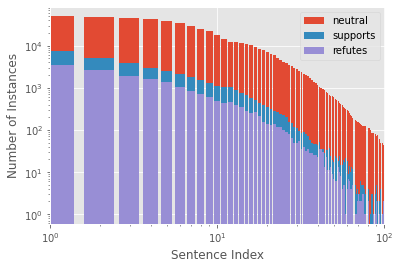

In [88]:
for series in zip(*val):
    plt.bar(pos,series)

plt.xlabel('Sentence Index')
plt.ylabel("Number of Instances")
plt.yscale('log')
plt.xscale('log')
plt.xlim((1,101))
plt.legend(["neutral","supports","refutes"])
plt.savefig("bias_sentence_distribution.pdf",bbox_inches='tight')

In [72]:
master_distribution = [0,0,0]

for idx,dist in zip(pos,val):
    master_distribution[0] += dist[0]
    master_distribution[1] += dist[1]
    master_distribution[2] += dist[2]
    
norm_ms = [a/sum(master_distribution) for a in master_distribution]
norm_ms

[0.8795707623272018, 0.08194565037232125, 0.03848358730047702]

In [73]:
infos = []
for idx,dist in zip(pos,val):
    infos.append(D_kl(norm_ms,normalize(dist)))

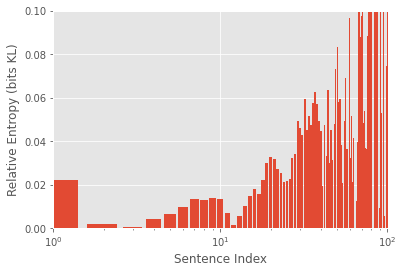

In [89]:

plt.bar(pos,infos)

plt.autoscale(tight=True)
plt.xscale('log')
plt.ylim((0,0.1))
plt.xlim((1,101))
plt.xlabel("Sentence Index")
plt.ylabel("Relative Entropy (bits KL)")
plt.savefig("bias_sentence_relative_entropy.pdf",bbox_inches='tight')


In [84]:
with open("nc_cumulative_totals.json","w+") as f:
    json.dump([cum_totals_true,cum_totals_false],f)